# Temp PR with pandas

In [3]:
import scipy.stats
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import operator
import copy
from datetime import datetime, timedelta
import os.path
import pandas as pd

In [12]:
# gives a dataframe from data
def get_data(filepath, n = None):
    edges_df = pd.read_csv(filepath, sep=' ', names=["time","source","target"], nrows = n)  
    return edges_df

In [16]:
filepath = '/mnt/idms/temporalNodeRanking/data/filtered_timeline_data/tsv/15o/15o_only_first_mentions.csv'
df = get_data(filepath, 15)
df

,time,source,target
0,1318244928,35934,28197
1,1318244934,37953,59848
2,1318244938,36223,47353
3,1318244938,36223,10583
4,1318244939,33489,28197
5,1318244957,37591,52903
6,1318244961,39361,54059
7,1318244962,64210,28197
8,1318244966,50667,47309
9,1318244973,45236,29596


In [23]:
def get_graph_from_df(df):
    G = nx.MultiDiGraph()

    for index, edge in df.iterrows():
        G.add_edge(edge[1], edge[2], time = edge[0], weight = 1.0)

    #nrm = float(sum(edges.values()))
    #G.add_edges_from([(k[0],k[1], {'weight': v}) for k,v in edges.items()])
    #G.add_edges_from([tuple(edge)])
    return G

In [24]:
G = get_graph_from_df(df)

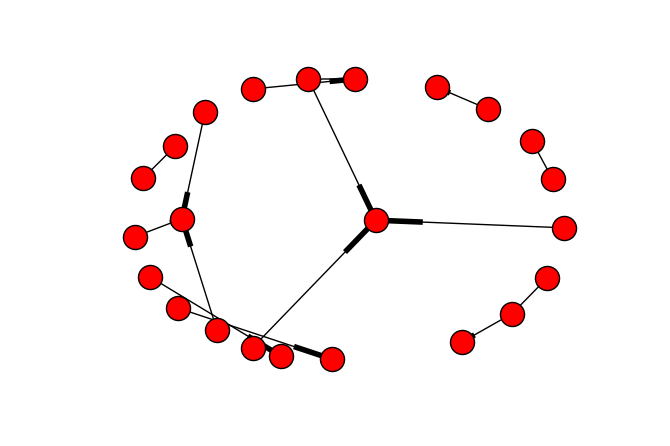

In [29]:
%matplotlib inline
nx.draw(G)

In [ ]:
def first_n_edge(filepath, n = 0):
    G = nx.DiGraph()
    edges_df = pd.read_csv(filepath, sep=' ', names=["time","source","target"])
    for i in iter(range(n)):
        if edges_df.ix[i]["source"] != edges_df.ix[i]["target"]:
            G.add_edge(edges_df.ix[i]["source"],edges_df.ix[i]["target"],{'time':edges_df.ix[i]["time"]})
        
    return G